# Library

In [5]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from torch.utils.data import Dataset
from tokenizers import BertWordPieceTokenizer, Tokenizer
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertForQuestionAnswering,
    BertConfig,
    Trainer,
    TrainingArguments,
)

c:\ProgramData\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BERT

reference: [BERT](https://wikidocs.net/115055) <br>
paper: [BERT](https://arxiv.org/pdf/1810.04805) 

## Implementation

In [29]:
def scaled_dot_product_attention(query, key, value, mask=None):
    # 쿼리와 키의 내적을 계산합니다.
    matmul_qk = query @ key.transpose(-2, -1)
    depth = query.shape[-1]

    # 스케일링을 적용합니다.
    logits = matmul_qk / np.sqrt(depth)

    # 마스크가 있을 경우 logits에 마스크를 적용합니다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수를 적용하여 어텐션 가중치를 계산합니다.
    attention_weights = F.softmax(logits, dim=-1)
    output = attention_weights @ value  # 어텐션 가중치를 값에 적용합니다.

    return output, attention_weights

class MultiheadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # num_heads로 나누어 떨어지지 않으면 오류를 발생시킵니다.
        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        # 쿼리, 키, 값을 위한 밀집 레이어를 정의합니다.
        self.query_dense = nn.Linear(self.d_model, self.d_model)
        self.key_dense = nn.Linear(self.d_model, self.d_model)
        self.value_dense = nn.Linear(self.d_model, self.d_model)

        # 최종 출력을 위한 밀집 레이어를 정의합니다.
        self.dense = nn.Linear(self.d_model, self.d_model)
    
    def forward(self, inputs: dict):
        # 쿼리, 키, 값, 마스크를 입력으로 받습니다.
        query, key, value = inputs.get('query'), inputs.get('key'), inputs.get('value')
        mask = inputs.get('mask')
        batch_size, seq_len = query.shape[:2]

        # 쿼리, 키, 값을 밀집 레이어에 통과시킵니다.
        query = self.query_dense(query)  # batch_size, seq_len, dim
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 다중 헤드로 나누어 줍니다.
        query = query.reshape(batch_size, seq_len, self.num_heads, self.depth)  # batch, seq_len, num_heads, depth
        key = key.reshape(batch_size, seq_len, self.num_heads, self.depth)
        value = value.reshape(batch_size, seq_len, self.num_heads, self.depth)

        # 차원 순서를 변경합니다.
        query = query.permute(0, 2, 1, 3)   # batch, num_heads, seq_len, depth
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        # 스케일드 점곱 어텐션을 계산합니다.
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)  # batch, seq_len, num_heads, depth
        concat_attention = scaled_attention.reshape(batch_size, seq_len, self.d_model)  # batch, seq_len, dim

        # 최종 출력을 생성합니다.
        outputs = self.dense(concat_attention)  # batch, seq_len, dim

        return outputs

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, num_heads: int, dropout_ratio: float):    
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_ratio = dropout_ratio

        # 멀티헤드 어텐션 레이어를 정의합니다.
        self.multi_head_attention = MultiheadAttention(self.d_model, self.num_heads)
        self.dropout1 = nn.Dropout(self.dropout_ratio)
        self.layer_norm1 = nn.LayerNorm(self.d_model)

        # 피드포워드 네트워크를 정의합니다.
        self.ffn = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model),
        )

        self.dropout2 = nn.Dropout(self.dropout_ratio)
        self.layer_norm2 = nn.LayerNorm(self.d_model)

    def forward(self, x, mask=None):
        # 멀티헤드 어텐션을 통과시킵니다.
        inputs = {'query': x, 'key': x, 'value': x, 'mask': mask}
        x_multi_head_output = self.multi_head_attention(inputs)
        x_multi_head_output = self.dropout1(x_multi_head_output)
        x = self.layer_norm1(x_multi_head_output + x)  # 잔차 연결을 적용합니다.
        
        # 피드포워드 네트워크를 통과시킵니다.
        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output)
        output = self.layer_norm2(x + ffn_output)  # 잔차 연결을 적용합니다.

        return output

class BERT(nn.Module):
    def __init__(
        self,
        seq_len: int,
        vocab_size: int,
        num_layers: int,
        d_model: int,
        d_ff: int,
        num_heads: int,
        dropout_ratio: float,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_ratio = dropout_ratio

        # 임베딩 레이어를 정의합니다.
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.positional_embedding = nn.Embedding(self.seq_len, self.d_model)
        self.segment_embedding = nn.Embedding(2, self.d_model)
        
        # 인코더 레이어를 생성합니다.
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(self.d_model, self.d_ff, self.num_heads, self.dropout_ratio)
            for _ in range(self.num_layers)
        ])
    
    def forward(self, x, mask=None):
        # 입력 임베딩을 생성합니다.
        x = self.embedding(x)
        x *= (self.d_model ** 0.5)

        # 위치 인코딩을 추가합니다.
        positional_encoding = (torch.ones(x.shape[:2]).cumsum(axis=1) - 1).long()
        positional_embedding = self.positional_embedding(positional_encoding)
        x += positional_embedding

        # 세그먼트 인코딩을 추가합니다.
        segment_encoding = torch.zeros(x.shape[:2]).long()
        segment_embedding = self.segment_embedding(segment_encoding)
        x += segment_embedding

        # 각 인코더 레이어를 통과시킵니다.
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask)
        output = x

        return output  # 최종 출력을 반환합니다.

In [31]:
# 임의의 입력 데이터 생성: (batch_size=32, seq_len=20) 크기의 텐서를 생성합니다.
# 값은 0에서 999 사이의 정수로 설정합니다.
x = torch.randint(0, 1000, (32, 20))

# BERT 모델 초기화: 
# seq_len=20, vocab_size=1000, num_layers=12, d_model=768, d_ff=2048, num_heads=12, dropout_ratio=0.1
bert = BERT(20, 1000, 12, 768, 2048, 12, 0.1)

# BERT 모델에 입력 데이터를 통과시켜 출력을 생성합니다.
output = bert(x)

# 출력 텐서를 확인합니다.
print(output)

tensor([[[-0.2906, -0.6584,  1.9619,  ..., -1.0357, -0.2678,  0.5728],
         [-0.0104, -1.9197,  1.0588,  ..., -0.2179, -1.6125, -0.0701],
         [ 0.5030,  0.0756,  1.1953,  ...,  0.5741, -1.0067,  1.6260],
         ...,
         [-0.1088, -0.2704,  0.4653,  ..., -0.2513, -1.8823, -0.3770],
         [ 0.6014, -1.2329,  0.6875,  ..., -0.1052, -1.5198,  0.4144],
         [ 0.1390, -1.5423,  0.5434,  ..., -0.9341, -0.8175, -0.2473]],

        [[ 0.2578,  0.4389, -0.5429,  ..., -1.3440,  0.8259, -0.4212],
         [-0.2401, -0.3437, -0.2433,  ..., -1.4168, -0.0399,  0.1204],
         [ 1.0967, -0.4443,  0.7128,  ..., -1.0174,  1.0468,  0.8848],
         ...,
         [-0.5167, -0.3882, -0.8720,  ...,  0.1111,  0.3167, -0.2946],
         [ 0.3027, -1.2595,  0.0768,  ..., -0.4451,  0.6046, -0.4611],
         [-0.8294,  0.0169,  0.5167,  ..., -0.1644,  0.0142,  1.4447]],

        [[ 0.4527, -0.6503,  0.2345,  ..., -0.1982, -1.2915,  0.1563],
         [ 0.8184, -0.3630,  0.5080,  ...,  0

## Pre-training

### Tokenizer

In [253]:
# BertWordPieceTokenizer 초기화: 소문자 변환을 활성화합니다.
tokenizer = BertWordPieceTokenizer(lowercase=True)

# 훈련 데이터에서 문장 목록을 가져옵니다.
sentences = train['sentence1'].tolist()

# 문장을 기반으로 WordPiece 토크나이저를 훈련합니다.
# vocab_size는 30,000, 최소 빈도수는 3으로 설정합니다.
tokenizer.train_from_iterator(sentences, vocab_size=30000, min_frequency=3)

# 훈련된 어휘를 JSON 파일로 저장합니다.
tokenizer.save('./custom_bert_vocab.json')

# 저장된 어휘를 파일에서 불러옵니다.
tokenizer = Tokenizer.from_file('./custom_bert_vocab.json')

In [254]:
# 주어진 문장을 토크나이즈하여 토큰 목록을 생성합니다.
tokens = tokenizer.encode('안녕하세요').tokens

# 생성된 토큰 목록을 출력합니다.
print(tokens)

['안', '##녀', '##ᆼ', '##하', '##세', '##요']

### Pre-training

## Fine-tuning

### Sentiment Analysis

In [32]:
dataset = load_dataset('imdb')

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 426128.28 examples/s]


In [63]:
# 훈련 데이터에서 처음 2000개의 샘플을 선택하여 train_data로 설정합니다.
train_data = dataset['train'].select(range(2000))

# 테스트 데이터에서 처음 2000개의 샘플을 선택하여 eval_data로 설정합니다.
eval_data = dataset['test'].select(range(2000))

In [64]:
# 사용할 BERT 모델의 이름을 설정합니다.
model_name = 'bert-base-uncased'

# 미리 학습된 BERT 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocessing(row):
    # 각 데이터 행의 'text' 컬럼을 토크나이즈합니다.
    # 최대 길이를 256으로 설정하고, 패딩을 적용하며, 필요 시 잘라냅니다.
    return tokenizer(row['text'], truncation=True, max_length=256, padding='max_length')

# 훈련 데이터에 대해 전처리를 수행하여 토크나이즈된 데이터를 생성합니다.
tokenized_train_data = train_data.map(preprocessing, batched=True)

# 평가 데이터에 대해 전처리를 수행하여 토크나이즈된 데이터를 생성합니다.
tokenized_eval_data = eval_data.map(preprocessing, batched=True)

In [73]:
# 토크나이즈된 훈련 데이터에서 필요한 필드를 추출하여 딕셔너리 형태로 변환합니다.
train_data = [
    {
        'input_ids': row.get('input_ids'),
        'token_type_ids': row.get('token_type_ids'),
        'attention_mask': row.get('attention_mask'),
        'label': row.get('label'),
    } for row in tokenized_train_data
]

# 토크나이즈된 평가 데이터에서 필요한 필드를 추출하여 딕셔너리 형태로 변환합니다.
eval_data = [
    {
        'input_ids': row.get('input_ids'),
        'token_type_ids': row.get('token_type_ids'),
        'attention_mask': row.get('attention_mask'),
        'label': row.get('label'),
    } for row in tokenized_eval_data
]

# PyTorch Dataset을 상속받은 IMDBDataset 클래스 정의
class IMDBDataset(Dataset):
    def __init__(self, data):
        # 데이터 초기화
        self.data = data
    
    def __len__(self):
        # 데이터의 길이를 반환합니다.
        return len(self.data)
    
    def __getitem__(self, idx):
        # 주어진 인덱스의 데이터를 반환합니다.
        return {
            'input_ids': self.data[idx].get('input_ids'),
            'attention_mask': self.data[idx].get('attention_mask'),
            'labels': self.data[idx].get('label'),
        }

# IMDBDataset 클래스를 사용하여 훈련 및 평가 데이터셋 생성
train_dataset = IMDBDataset(train_data)
eval_dataset = IMDBDataset(eval_data)

In [ ]:
# 훈련 매개변수를 설정합니다.
training_args = TrainingArguments(
    output_dir='./results',                   # 결과 저장 디렉토리
    eval_strategy='epoch',                    # 평가 전략: 에포크마다 평가
    learning_rate=2e-5,                       # 학습률
    per_device_train_batch_size=16,           # 장치당 훈련 배치 크기
    per_device_eval_batch_size=16,            # 장치당 평가 배치 크기
    num_train_epochs=2,                       # 훈련할 에포크 수
    weight_decay=0.01,                        # 가중치 감쇠
)

# 미리 학습된 BERT 모델을 불러옵니다 (분류용).
model = BertForSequenceClassification.from_pretrained(model_name)

# Trainer 객체를 초기화합니다.
trainer = Trainer(
    model=model,                              # 사용할 모델
    args=training_args,                       # 훈련 매개변수
    train_dataset=train_dataset,              # 훈련 데이터셋
    eval_dataset=eval_dataset,                # 평가 데이터셋
)

# 모델을 훈련합니다.
trainer.train()

#### 유튜브

In [77]:
import urllib.request

# NSMC 훈련 데이터 다운로드
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/e9t/nsmc/refs/heads/master/ratings_train.txt',
    filename='data/ratings_train.txt',  # 저장할 파일 경로 및 이름
)

# NSMC 테스트 데이터 다운로드
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/e9t/nsmc/refs/heads/master/ratings_test.txt',
    filename='data/ratings_test.txt',   # 저장할 파일 경로 및 이름
)


('data/ratings_test.txt', <http.client.HTTPMessage at 0x25b7b31fa30>)

In [2]:
# 훈련 데이터셋을 로드하고 'document'와 'label' 컬럼만 선택합니다.
# 처음 5000개의 샘플을 사용합니다.
train = pd.read_table('data/ratings_train.txt', usecols=['document', 'label']).iloc[:5000]

# 검증 데이터셋을 로드하고 'document'와 'label' 컬럼만 선택합니다.
# 처음 5000개의 샘플을 사용합니다.
valid = pd.read_table('data/ratings_test.txt', usecols=['document', 'label']).iloc[:5000]

In [3]:
# 다국어 지원 BERT 모델의 미리 학습된 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-multilingual-uncased')

<Axes: >

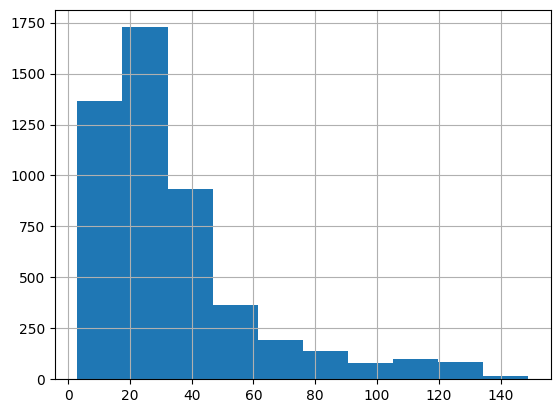

In [4]:
# 훈련 데이터의 'document' 컬럼을 토크나이즈하여 'tokenized_comment' 컬럼에 저장합니다.
train['tokenized_comment'] = train.document.apply(lambda x: tokenizer(x))

# 검증 데이터의 'document' 컬럼을 토크나이즈하여 'tokenized_comment' 컬럼에 저장합니다.
valid['tokenized_comment'] = valid.document.apply(lambda x: tokenizer(x))

# 훈련 데이터의 'tokenized_comment'에서 'input_ids'의 길이를 계산하여 히스토그램을 그립니다.
train.tokenized_comment.apply(lambda x: x.get('input_ids')).apply(len).hist()

In [6]:
# 훈련 데이터의 문장을 토크나이즈하여 텐서 형태로 변환합니다.
tokenized_train_comment = tokenizer(
    train.document.tolist(),               # 훈련 데이터의 문장 목록
    return_tensors='pt',                  # 파이토치 텐서로 반환
    padding='max_length',                  # 최대 길이에 맞춰 패딩
    max_length=100,                        # 최대 길이 100
    truncation=True,                       # 초과하는 경우 잘라냄
)

# 검증 데이터의 문장을 토크나이즈하여 텐서 형태로 변환합니다.
tokenized_valid_comment = tokenizer(
    valid.document.tolist(),                # 검증 데이터의 문장 목록
    return_tensors='pt',                   # 파이토치 텐서로 반환
    padding='max_length',                   # 최대 길이에 맞춰 패딩
    max_length=100,                         # 최대 길이 100
    truncation=True,                        # 초과하는 경우 잘라냄
)

# 훈련 데이터셋을 구성하는 리스트 생성
train_data = [
    {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask,
        'label': label,
    } 
    for input_ids, token_type_ids, attention_mask, label 
    in zip(tokenized_train_comment.get('input_ids'),
           tokenized_train_comment.get('token_type_ids'),
           tokenized_train_comment.get('attention_mask'),
           train.label.values)  # 레이블 추가
]

# 검증 데이터셋을 구성하는 리스트 생성
eval_data = [
    {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask,
        'label': label,
    } 
    for input_ids, token_type_ids, attention_mask, label 
    in zip(tokenized_valid_comment.get('input_ids'),
           tokenized_valid_comment.get('token_type_ids'),
           tokenized_valid_comment.get('attention_mask'),
           valid.label.values)  # 올바른 레이블 추가
]

# PyTorch Dataset을 상속받은 CommentDataset 클래스 정의
class CommentDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 주어진 인덱스의 데이터를 반환합니다.
        return {
            'input_ids': self.data[idx].get('input_ids'),
            'attention_mask': self.data[idx].get('attention_mask'),
            'labels': self.data[idx].get('label'),
        }

# 훈련 및 검증 데이터셋 인스턴스 생성
train_dataset = CommentDataset(train_data)
eval_dataset = CommentDataset(eval_data)

In [ ]:
# 훈련 매개변수를 설정합니다.
training_args = TrainingArguments(
    output_dir='./results',                  # 결과 저장 디렉토리
    eval_strategy='epoch',                   # 평가 전략: 에포크마다 평가
    learning_rate=2e-5,                      # 학습률
    per_device_train_batch_size=16,          # 장치당 훈련 배치 크기
    per_device_eval_batch_size=16,           # 장치당 평가 배치 크기
    num_train_epochs=2,                      # 훈련할 에포크 수
    weight_decay=0.01,                       # 가중치 감쇠
)

# 미리 학습된 다국어 BERT 모델을 불러옵니다 (분류용).
model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-uncased')

# Trainer 객체를 초기화합니다.
trainer = Trainer(
    model=model,                             # 사용할 모델
    args=training_args,                      # 훈련 매개변수
    train_dataset=train_dataset,             # 훈련 데이터셋
    eval_dataset=eval_dataset,               # 평가 데이터셋
)

# 모델을 훈련합니다.
trainer.train()

In [24]:
# 검증 데이터에서 3번째 문서를 토크나이즈하고, 모델에 입력하여 예측 결과를 얻습니다.
# 'return_tensors'를 'pt'로 설정하여 파이토치 텐서로 반환합니다.
inputs = tokenizer(valid.document.iloc[3], return_tensors='pt')

# 모델에 입력하여 로짓(logits)을 계산하고, 가장 높은 확률을 가진 클래스의 인덱스를 찾습니다.
predicted_label = model(**inputs).logits.argmax(axis=-1)

# 예측된 레이블을 출력합니다.
predicted_label

tensor([0])

### Natural Language Inference (NLI)

#### NLI

In [6]:
dataset = load_dataset('snli')

In [7]:
# 훈련 데이터셋에서 처음 1000개의 샘플을 선택합니다.
train_dataset = dataset['train'].select(range(1000))

# 검증 데이터셋에서 처음 1000개의 샘플을 선택합니다.
valid_dataset = dataset['validation'].select(range(1000))

In [8]:
# BERT 모델의 이름을 지정합니다. 여기서는 소문자 처리가 된 BERT 모델을 사용합니다.
model_name = 'bert-base-uncased'

# 미리 학습된 BERT 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained(model_name)

In [9]:
def preprocessing(row):
    # 주어진 행(row)에서 전제(premise)와 가설(hypothesis)을 토크나이즈합니다.
    return tokenizer(
        row['premise'],                          # 전제 문장
        row['hypothesis'],                       # 가설 문장
        truncation=True,                        # 길이가 max_length를 초과하는 경우 잘라냄
        padding=True,                           # 최대 길이에 맞춰 패딩 추가
        return_tensors='pt',                   # 파이토치 텐서로 반환
        max_length=128,                        # 최대 길이 설정
    )

In [11]:
# 훈련 데이터셋에 대해 전처리 함수를 적용하여 토크나이즈된 데이터셋을 생성합니다.
tokenized_train_dataset = train_dataset.map(preprocessing, batched=True)

# 검증 데이터셋에 대해 전처리 함수를 적용하여 토크나이즈된 데이터셋을 생성합니다.
tokenized_valid_dataset = valid_dataset.map(preprocessing, batched=True)

In [200]:
# 토크나이즈된 훈련 데이터셋을 리스트로 변환하며, 레이블이 -1이 아닌 데이터만 포함합니다.
tokenized_train_dataset = [
    {'input_ids': row.get('input_ids'),                # 입력 ID
     'token_type_ids': row.get('token_type_ids'),      # 토큰 타입 ID
     'attention_mask': row.get('attention_mask'),       # 어텐션 마스크
     'label': row.get('label')}                          # 레이블
    for row in tokenized_train_dataset
    if row.get('label') != -1                          # 레이블이 -1이 아닌 경우만 포함
]

# 토크나이즈된 검증 데이터셋을 리스트로 변환하며, 레이블이 -1이 아닌 데이터만 포함합니다.
tokenized_valid_dataset = [
    {'input_ids': row.get('input_ids'),                # 입력 ID
     'token_type_ids': row.get('token_type_ids'),      # 토큰 타입 ID
     'attention_mask': row.get('attention_mask'),       # 어텐션 마스크
     'label': row.get('label')}                          # 레이블
    for row in tokenized_valid_dataset
    if row.get('label') != -1                          # 레이블이 -1이 아닌 경우만 포함
]

In [201]:
class NLIDataset(Dataset):
    def __init__(self, data):
        # 데이터셋 초기화: 주어진 데이터를 저장합니다.
        self.data = data
    
    def __len__(self):
        # 데이터셋의 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 데이터 항목을 반환합니다.
        return {
            'input_ids': self.data[idx].get('input_ids'),          # 입력 ID
            'token_type_ids': self.data[idx].get('token_type_ids'),# 토큰 타입 ID
            'attention_mask': self.data[idx].get('attention_mask'), # 어텐션 마스크
            'labels': self.data[idx].get('label'),                  # 레이블
        }

In [202]:
# 토크나이즈된 훈련 데이터셋을 NLIDataset 클래스를 사용하여 데이터셋 객체로 변환합니다.
train_dataset = NLIDataset(tokenized_train_dataset)

# 토크나이즈된 검증 데이터셋을 NLIDataset 클래스를 사용하여 데이터셋 객체로 변환합니다.
valid_dataset = NLIDataset(tokenized_valid_dataset)

In [116]:
# 학습을 위한 파라미터 설정
training_args = TrainingArguments(
    output_dir='./results/NLI',                   # 결과 저장 디렉토리
    eval_strategy='epoch',                         # 평가 전략: 매 에폭마다 평가
    learning_rate=2e-5,                           # 학습률
    warmup_steps=50,                              # 웜업 단계 수
    per_device_train_batch_size=16,               # 디바이스당 훈련 배치 크기
    per_device_eval_batch_size=16,                # 디바이스당 평가 배치 크기
    num_train_epochs=1,                           # 훈련 에폭 수
    weight_decay=0.01,                            # 가중치 감소
    logging_dir='./logs',                         # 로그 저장 디렉토리
)

# 미리 학습된 BERT 모델을 로드하고, 레이블 수를 설정합니다. 여기서는 3개의 레이블이 있습니다.
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Trainer 객체를 생성하여 모델, 학습 인자, 훈련 데이터셋, 평가 데이터셋을 지정합니다.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,                  # 훈련 데이터셋
    eval_dataset=valid_dataset,                   # 검증 데이터셋
)

# 모델을 훈련합니다.
trainer.train()

# 훈련된 모델을 저장합니다.
model.save_pretrained('./bert_nli')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 32%|███▏      | 20/63 [07:00<15:04, 21.04s/it]
                                               
100%|██████████| 63/63 [03:29<00:00,  3.32s/it]


{'eval_loss': 1.0193928480148315, 'eval_runtime': 47.6332, 'eval_samples_per_second': 20.574, 'eval_steps_per_second': 1.302, 'epoch': 1.0}
{'train_runtime': 209.456, 'train_samples_per_second': 4.765, 'train_steps_per_second': 0.301, 'train_loss': 1.1285164242699033, 'epoch': 1.0}


#### KoNLI

In [221]:
# SNLI 데이터셋을 TSV 형식으로 읽어옵니다. 
# 데이터는 탭('\t')으로 구분되어 있습니다.
data = pd.read_csv('./data/snli_1.0_train.ko.tsv', sep='\t')

In [222]:
def convert_label_to_ids(label: str):
    # 레이블을 정수 ID로 변환하는 딕셔너리 정의
    ids = {
        'entailment': 0,     # 포함 관계
        'neutral': 1,        # 중립
        'contradiction': 2,  # 모순
    }
    # 주어진 레이블에 해당하는 ID를 반환, 없으면 None 반환
    return ids.get(label)

# 데이터프레임의 'gold_label' 컬럼에 대해 convert_label_to_ids 함수를 적용하여 정수 ID로 변환
data.gold_label = data.gold_label.apply(lambda x: convert_label_to_ids(x))

In [223]:
from sklearn.model_selection import train_test_split

# 랜덤 시드를 설정하여 결과의 재현성을 보장합니다.
seed = 0

# 데이터의 처음 5000개 샘플만 선택합니다.
data = data.iloc[:5000]

# 전체 데이터를 80% 훈련 데이터와 20% 테스트/검증 데이터로 분할합니다.
train, temp = train_test_split(data, test_size=0.2, random_state=seed)

# 나머지 20%의 데이터(temp)를 다시 50%씩 나누어 검증(valid)과 테스트(test) 데이터로 분할합니다.
valid, test = train_test_split(temp, test_size=0.5, random_state=seed)


In [224]:
# 다국어 BERT 모델의 토크나이저를 로드합니다.
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-multilingual-uncased')

# 훈련 데이터의 'sentence1'과 'sentence2'를 토큰화하여 'tokenized' 컬럼에 저장합니다.
train['tokenized'] = train.apply(lambda x: tokenizer(
    x['sentence1'],        # 첫 번째 문장
    x['sentence2'],        # 두 번째 문장
    truncation=True,       # 문장이 max_length를 초과할 경우 잘라냄
    padding='max_length',  # max_length에 맞춰 패딩 추가
    max_length=128,       # 최대 길이 설정
    return_tensors='pt'   # PyTorch 텐서로 반환
), axis=1)

# 검증 데이터에 대해서도 동일한 방식으로 토큰화합니다.
valid['tokenized'] = valid.apply(lambda x: tokenizer(
    x['sentence1'],
    x['sentence2'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
), axis=1)

# 테스트 데이터에 대해서도 동일한 방식으로 토큰화합니다.
test['tokenized'] = test.apply(lambda x: tokenizer(
    x['sentence1'],
    x['sentence2'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
), axis=1)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [226]:
class KorNLIDataset(Dataset):
    def __init__(self, data):
        # 데이터프레임을 클래스 속성으로 저장합니다.
        self.data = data
    
    def __len__(self):
        # 데이터셋의 크기를 반환합니다.
        return len(self.data)
    
    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터를 가져옵니다.
        temp = self.data.iloc[idx].tokenized
        
        # 토큰화된 데이터를 딕셔너리 형식으로 변환합니다.
        temp = {
            'input_ids': temp.get('input_ids')[0],           # 입력 ID
            'token_type_ids': temp.get('token_type_ids')[0], # 토큰 유형 ID
            'attention_mask': temp.get('attention_mask')[0], # 어텐션 마스크
            'labels': self.data.iloc[idx].gold_label          # 레이블
        }

        return temp

In [227]:
# KorNLIDataset 클래스를 사용하여 훈련, 검증, 테스트 데이터셋을 초기화합니다.
train_dataset = KorNLIDataset(train)  # 훈련 데이터셋
valid_dataset = KorNLIDataset(valid)  # 검증 데이터셋
test_dataset = KorNLIDataset(test)    # 테스트 데이터셋

In [ ]:
# 훈련을 위한 하이퍼파라미터를 설정합니다.
training_args = TrainingArguments(
    output_dir='./KoNLI/results/',            # 결과 저장 디렉토리
    eval_strategy='epoch',                     # 평가 전략: 매 에포크마다 평가
    learning_rate=2e-5,                       # 학습률
    warmup_steps=50,                          # 웜업 스텝 수
    per_device_train_batch_size=16,           # 장치당 훈련 배치 크기
    per_device_eval_batch_size=16,            # 장치당 평가 배치 크기
    num_train_epochs=1,                        # 훈련 에포크 수
    weight_decay=0.01,                        # 가중치 감소
    logging_dir='./KoNLI/logs',               # 로그 저장 디렉토리
)

# BERT 모델을 사전 훈련된 가중치로 초기화합니다.
model = BertForSequenceClassification.from_pretrained(
    'google-bert/bert-base-multilingual-uncased', num_labels=3  # 클래스 수: 3 (entailment, neutral, contradiction)
)

# Trainer를 초기화하여 모델 훈련을 준비합니다.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # 훈련 데이터셋
    eval_dataset=valid_dataset,    # 검증 데이터셋
)

# 모델을 훈련합니다.
trainer.train()

# 훈련된 모델을 지정한 경로에 저장합니다.
model.save_pretrained('./bert_nli')

### Question and Answering